<a href="https://colab.research.google.com/github/Rohan-GTHUB/Moon-PSR-Enhancement-/blob/main/OriginalPSRG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow keras numpy matplotlib opencv-python


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Pre-processing Input Data (OHRC and IIRS images)**

In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

# Define your dataset paths here
ohrc_image_path = "/content/drive/MyDrive/data_sci/ohrc"
iirs_image_path = "/content/drive/MyDrive/data_sci/iirs"

# Function to load and preprocess images
def preprocess_images(image_path, img_size=(256, 256)):
    images = []
    for file in os.listdir(image_path):
        img = cv2.imread(os.path.join(image_path, file))                                             # Reading images using opencv
        if img is not None:
            img = cv2.resize(img, img_size)
            img = img / 255.0                                                                        # Normalize to [0, 1]
            images.append(img)                                                                       # Add processed image to list
    return np.array(images)                                                                          # Convert list of images to numpy array and return

#    work of the above defined function:
#     1. Creates empty list for storing images
#     2. Reads each image from the directory
#     3. Processes each image
#     4. Returns array of processed images

# Load OHRC and IIRS images
ohrc_images = preprocess_images(ohrc_image_path)
iirs_images = preprocess_images(iirs_image_path)

print("OHRC Images Shape:", ohrc_images.shape)                                                       # Print shapes of processed image arrays
print("IIRS Images Shape:", iirs_images.shape)
# print(ohrc_images)


OHRC Images Shape: (2, 256, 256, 3)
IIRS Images Shape: (3, 256, 256, 3)
[[[[0.00784314 0.00784314 0.00784314]
   [0.00392157 0.00392157 0.00392157]
   [0.00784314 0.00784314 0.00784314]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00392157 0.00392157 0.00392157]
   [0.00784314 0.00784314 0.00784314]]

  [[0.00784314 0.00784314 0.00784314]
   [0.00392157 0.00392157 0.00392157]
   [0.00784314 0.00784314 0.00784314]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]]

  [[0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   ...
   [0.00392157 0.00392157 0.00392157]
   [0.00392157 0.00392157 0.00392157]
   [0.00784314 0.00784314 0.00784314]]

  ...

  [[0.23921569 0.23921569 0.23921569]
   [0.4        0.4        0.4       ]
   [0.50588235 0.50588235 0.50588235]
   ...
   [0.00784314 0.00784314 0.00784314]
   [0.00784314 0.00784314 0.00784314]
   [0.0078431

Now images are turened into nd array

**Defining** **Shared Encoder with** **Dual** **Outputs**

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate
from tensorflow.keras.models import Model

def build_shared_encoder(input_shape=(256, 256, 3)):
    input_layer = Input(shape=input_shape)                                                                          #input layer

    # Shared Convolutional Layers
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)                                          # First Convolutional Block
    # 32 = number of filters
    # (3, 3) = filter size
    # relu = activation function
    # padding='same' = output size same as input
    x = MaxPooling2D((2, 2))(x)                                                                                     # Maxpooling used to reduced the images size || Reduces image size by half
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                                                    # Second Convolutional Block ||Relu : Negative values ko 0 kar dega, positive values retain karega
    x = MaxPooling2D((2, 2))(x)

    # Branch for Structural Embeddings
    structural_branch = Flatten()(x)                                                                                # Converts 2D feature maps to 1D vector
    structural_embedding = Dense(128, activation='relu', name="structural_embedding")(structural_branch)

    # Branch for Resolution Embeddings
    resolution_branch = Flatten()(x)
    resolution_embedding = Dense(128, activation='relu', name="resolution_embedding")(resolution_branch)

    model = Model(inputs=input_layer, outputs=[structural_embedding, resolution_embedding])
    return model
    # Creates final model with:
    # - One input (input_layer)
    # - Two outputs (structural_embedding, resolution_embedding)

shared_encoder = build_shared_encoder()
shared_encoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 32)   │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 32)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 262144)         │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ structural_embedding      │ (None, 128)            │     33,554,560 │ flatten[0][0]          │
│ (Dense)                   │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resolution_embedding      │ (None, 128)            │     33,554,560 │ flatten_1[0][0]        │
│ (Dense)                   │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 67,128,512 (256.07 MB)

 Trainable params: 67,128,512 (256.07 MB)

 Non-trainable params: 0 (0.00 B)

**embeddings portion need to be changed!!**

In [ ]:
# from tensorflow.keras.layers import Attention

# def attention_layer(inputs):
#     query, value = inputs
#     attn = Attention()([query, value])
#     return attn
# Query: Searching vector (kya dhundh rahe hai)
# Value: Information vector (kahan dhundh rahe hai)
# Work of attention mechanism:
# Compare decoder_state with each encoder_output
# Give weights to each feature based on similarity




Define Conditional GAN Architecture

In [ ]:
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.models import Sequential

# Define Generator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output to 3-channel image
    return model

# Define Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))  # OHRC + IIRS input
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)
    return model

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 512, 512, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 512, 512, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 512, 512, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,123 (82.51 KB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 256, 256, 64)        │           3,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1048576)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │       1,048,577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,052,097 (4.01 MB)

 Trainable params: 1,052,097 (4.01 MB)

 Non-trainable params: 0 (0.00 B)

Define Loss Functions and GAN Training Loop

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, UpSampling2D
from tensorflow.keras.models import Sequential, Model

# Defining the  Generator
def build_generator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output to 3-channel image
    return model

# Defining the Discriminator
def build_discriminator():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 6)))  # OHRC + IIRS input
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)
    return model

# Defining loss functions
def perceptual_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# Combine generator and discriminator into GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(256, 256, 3))
    enhanced_image = generator(gan_input)
    gan_output = discriminator(concatenate([gan_input, enhanced_image]))  # Concatenate input and enhanced image
    gan = Model(inputs=gan_input, outputs=gan_output)
    return gan



# Build and compile the models
generator = build_generator()
discriminator = build_discriminator()

# Compile the discriminator
discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

gan = build_gan(generator, discriminator)
gan.compile(optimizer='adam', loss='binary_crossentropy')
gan.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_6 (Sequential) │ (None, 256, 256, 3)    │         21,123 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 256, 256, 6)    │              0 │ input_layer_11[0][0],  │
│ (Concatenate)             │                        │                │ sequential_6[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_7 (Sequential) │ (None, 1)              │      1,052,097 │ concatenate_2[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,073,220 (4.09 MB)

 Trainable params: 21,123 (82.51 KB)

 Non-trainable params: 1,052,097 (4.01 MB)

Train the Model

In [ ]:
# Prepare training data
X = ohrc_images  # Input images
Y = iirs_images  # Target images for conditional GAN

# Training Loop
epochs = 10
batch_size = 16  # Consider reducing batch_size or making your datasets the same size
# Ensure that the batch_size can divide evenly into the smallest dimension
batch_size = min(batch_size, min(len(X), len(Y)))  # Ensure batch_size is suitable

for epoch in range(epochs):
    # Calculate the number of batches to cover the smaller dataset
    num_batches = min(len(X), len(Y)) // batch_size

    # Initialize epoch losses
    epoch_d_loss = 0
    epoch_g_loss = 0

    for batch in range(num_batches):
        # Ensure real_images and target_images have the same batch size
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size
        real_images = X[start_idx:end_idx]
        target_images = Y[start_idx:end_idx]

        # Generate fake images
        fake_images = generator.predict(real_images)

        # Train discriminator
        real_labels = np.ones((real_images.shape[0], 1))
        fake_labels = np.zeros((fake_images.shape[0], 1))
        d_loss_real = discriminator.train_on_batch(np.concatenate([real_images, target_images], axis=-1), real_labels)
        d_loss_fake = discriminator.train_on_batch(np.concatenate([real_images, fake_images], axis=-1), fake_labels)

        # Access the loss values (first element of the lists)
        d_loss_real = d_loss_real[0]  # Get the loss value from d_loss_real
        d_loss_fake = d_loss_fake[0]  # Get the loss value from d_loss_fake

        d_loss = 0.5 * (d_loss_real + d_loss_fake)
        epoch_d_loss += d_loss  # Accumulate discriminator loss

        # Train generator (via GAN)
        g_loss = gan.train_on_batch(real_images, real_labels)
        # Access the loss value (first element of the list)
        epoch_g_loss += g_loss[0]  # Accumulate generator loss only

    # Calculating the average epoch losses
    # Check if num_batches is 0 to prevent ZeroDivisionError
    if num_batches > 0:
        epoch_d_loss /= num_batches
        epoch_g_loss /= num_batches

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {epoch_d_loss:.4f} | G Loss: {epoch_g_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


Epoch 1/10 | D Loss: 0.7095 | G Loss: 0.7104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Epoch 2/10 | D Loss: 0.7101 | G Loss: 0.7108
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Epoch 3/10 | D Loss: 0.7106 | G Loss: 0.7113
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
Epoch 4/10 | D Loss: 0.7112 | G Loss: 0.7119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Epoch 5/10 | D Loss: 0.7118 | G Loss: 0.7124
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Epoch 6/10 | D Loss: 0.7124 | G Loss: 0.7129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
Epoch 7/10 | D Loss: 0.7129 | G Loss: 0.7135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Epoch 8/10 | D Loss: 0.7135 | G Loss: 0.7141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Epoch 9/10 | D Loss: 0.7141 | G Loss: 0.7147
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Epoch 10/10 | D Loss: 0.7147 | G Loss: 0.7153


Test the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


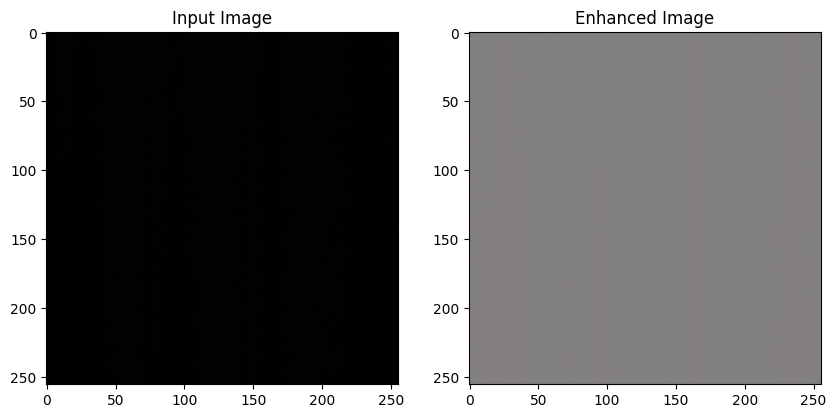

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


test_image_path = "/content/drive/MyDrive/data_sci/target/target01.tif"                                        #Providing Path for thentest images
test_image = cv2.imread(test_image_path)


if test_image is None:                                                                                         # Check if the image wasloaded successfully
    print(f"Error: Could not load image from {test_image_path}")
else:
    test_image = cv2.resize(test_image, (256, 256)) / 255.0
    test_image = np.expand_dims(test_image, axis=0)

    # Generate enhanced image
    enhanced_image = generator.predict(test_image)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(test_image[0])
    plt.subplot(1, 2, 2)
    plt.title("Enhanced Image")
    plt.imshow(enhanced_image[0])
    plt.show()

Apply Denoising and Further Enhancement

In [ ]:
import os


output_dir = "enhanced_images"                                                   #directory to store the output images
os.makedirs(output_dir, exist_ok=True)


def save_images(images, output_dir, prefix="enhanced"):                          # Saving the enhanced images to the output directory
    for idx, img in enumerate(images):
        img = (img * 255).astype('uint8')                                         # Convert back to 8-bit format
        save_path = os.path.join(output_dir, f"{prefix}_image_{idx+1}.png")
        cv2.imwrite(save_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))              # Convert to BGR for saving
        print(f"Saved: {save_path}")

# Generate and save enhanced images
enhanced_images = generator.predict(ohrc_images)                                  # Enhancing the OHRC images
save_images(enhanced_images, output_dir)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Saved: enhanced_images/enhanced_image_1.png
Saved: enhanced_images/enhanced_image_2.png


Apply Image Enhancement Techniques

In [ ]:
def enhance_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(img)
    return enhanced_img



# Define the path to the denoised image directory
denoised_dir = "/content/enhanced_images"

# Applying enhancement to denoised images
enhanced_dir = "final_enhanced_images"
os.makedirs(enhanced_dir, exist_ok=True)

for file in os.listdir(denoised_dir):
    file_path = os.path.join(denoised_dir, file)
    enhanced_img = enhance_image(file_path)
    save_path = os.path.join(enhanced_dir, f"final_{file}")
    cv2.imwrite(save_path, enhanced_img)
    print(f"Saved Final Enhanced Image: {save_path}")


Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_1.png
Saved Final Enhanced Image: final_enhanced_images/final_enhanced_image_2.png


 Visualize Results

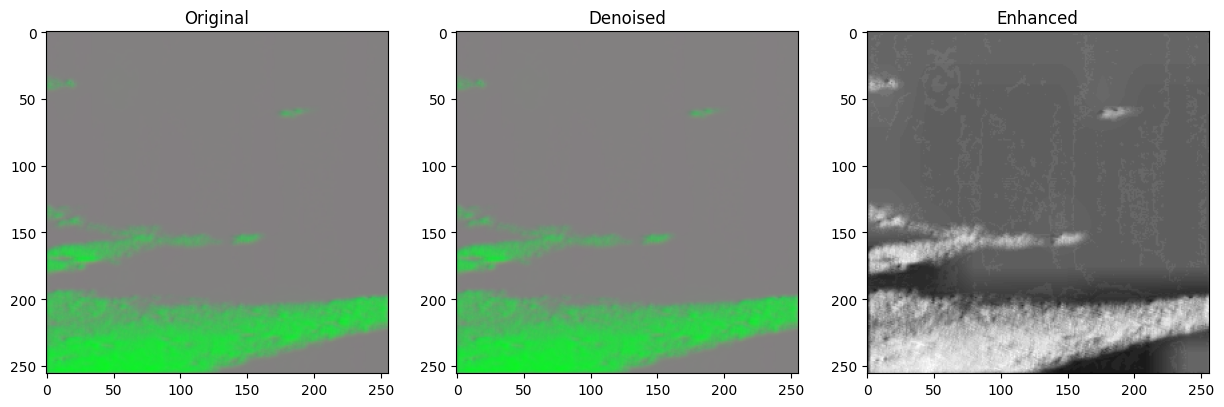

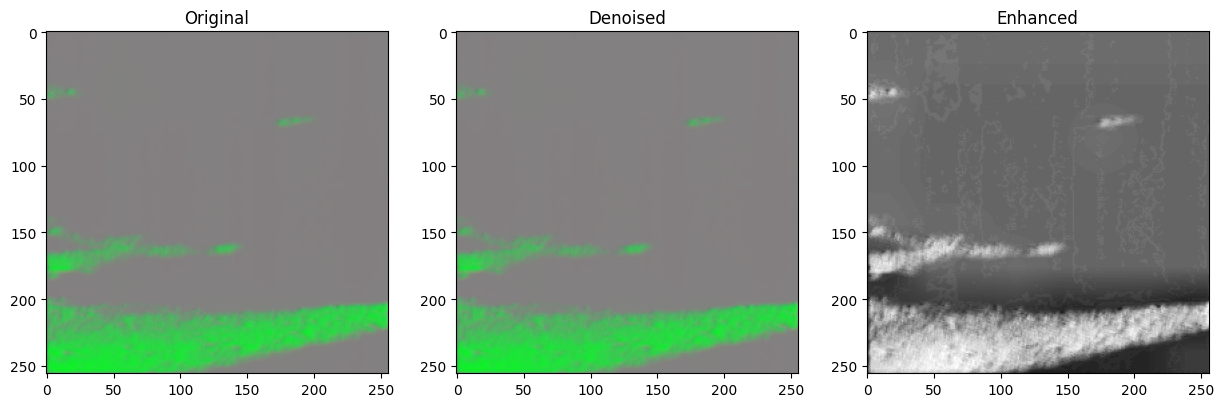

In [ ]:
# Visualize Original, Denoised, and Final Enhanced Images
def visualize_images(original_dir, denoised_dir, enhanced_dir, num_images=5):
    original_files = sorted(os.listdir(original_dir))[:num_images]
    denoised_files = sorted(os.listdir(denoised_dir))[:num_images]
    enhanced_files = sorted(os.listdir(enhanced_dir))[:num_images]

    for orig, denoised, enhanced in zip(original_files, denoised_files, enhanced_files):
        orig_img = cv2.imread(os.path.join(original_dir, orig))
        denoised_img = cv2.imread(os.path.join(denoised_dir, denoised))
        enhanced_img = cv2.imread(os.path.join(enhanced_dir, enhanced), cv2.IMREAD_GRAYSCALE)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 2)
        plt.title("Denoised")
        plt.imshow(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))
        plt.subplot(1, 3, 3)
        plt.title("Enhanced")
        plt.imshow(enhanced_img, cmap='gray')
        plt.show()

visualize_images(output_dir, denoised_dir, enhanced_dir)
